## Import library

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet_v2

Kelas yang tersedia: ['Primary Endo with Secondary Perio', 'Primary Endodontic Lesion', 'Primary Periodontal Lesion', 'True Combined Lesions']


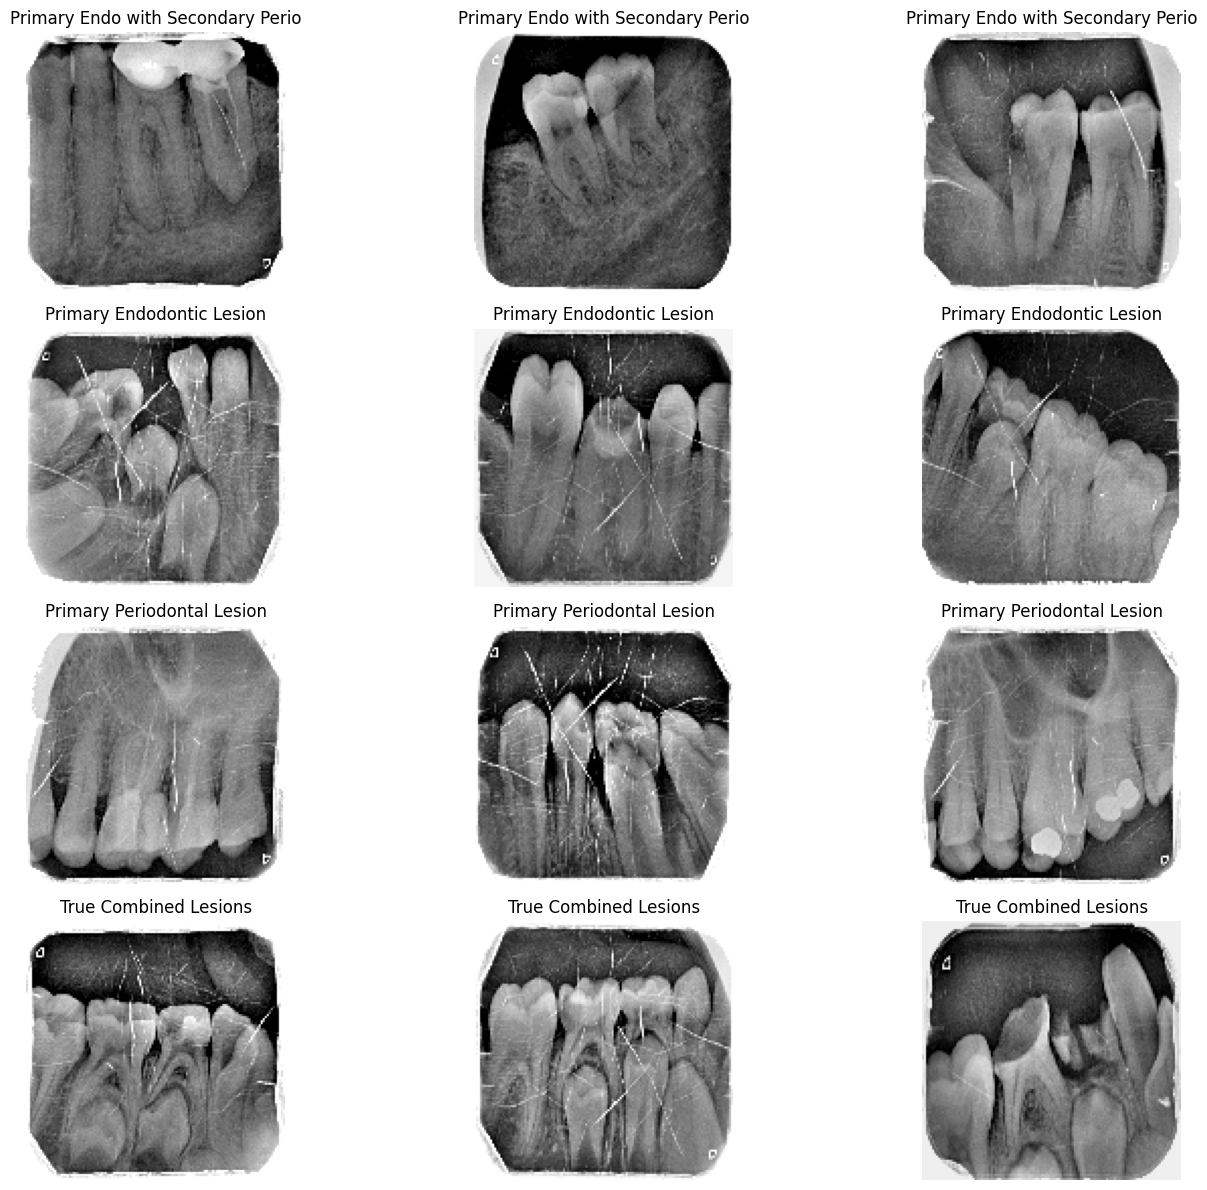

In [ ]:
import os
# Path ke folder utama dataset
dataset_path = "/content/drive/MyDrive/Periapical_Xrays4x2"  # Sesuaikan dengan struktur dataset

# Mendapatkan daftar kelas (subfolder dalam folder dataset)
classes = sorted(os.listdir(dataset_path))
print(f"Kelas yang tersedia: {classes}")

# Visualisasi beberapa gambar dari setiap kelas
def visualize_images(dataset_path, classes, num_images=3):
    plt.figure(figsize=(15, len(classes) * 3))
    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        images = os.listdir(class_path)[:num_images]  # Ambil sejumlah gambar
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.utils.load_img(img_path, target_size=(128, 128))  # Resize ke 128x128
            plt.subplot(len(classes), num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls)
    plt.tight_layout()
    plt.show()

# Tampilkan gambar
visualize_images(dataset_path, classes)



In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def stratified_split_dataset(source_dir, train_dir, val_dir, test_dir, train_size=0.6, val_size=0.2):
    # Buat direktori jika belum ada
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Loop melalui setiap kelas
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            # Ambil semua gambar dalam direktori kelas
            images = os.listdir(class_path)

            # Buat label yang sesuai dengan jumlah gambar
            labels = [class_name] * len(images)

            # Split data secara stratified untuk train dan sisanya (val + test)
            train_images, val_test_images, _, val_test_labels = train_test_split(
                images, labels, test_size=1 - train_size, stratify=labels, random_state=42
            )

            # Hitung proporsi val_size relatif terhadap (val + test)
            test_size_adjusted = (1 - train_size - val_size) / (1 - train_size)

            # Split data val dan test secara stratified
            val_images, test_images = train_test_split(
                val_test_images, test_size=test_size_adjusted, stratify=val_test_labels, random_state=42
            )

            # Fungsi untuk menyalin file
            def copy_images(images, src_class_path, dst_dir):
                for img in images:
                    src = os.path.join(src_class_path, img)
                    dst = os.path.join(dst_dir, class_name)
                    os.makedirs(dst, exist_ok=True)  # Buat direktori kelas
                    shutil.copy(src, dst)

            # Salin data ke direktori masing-masing
            copy_images(train_images, class_path, train_dir)
            copy_images(val_images, class_path, val_dir)
            copy_images(test_images, class_path, test_dir)

            # Print jumlah gambar yang disalin untuk setiap kelas
            print(f"Class '{class_name}': {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")

# Define paths
dataset_path = "/content/drive/MyDrive/Periapical_Xrays4x2"
train_directory = "/content/train"
val_directory = "/content/val"
test_directory = "/content/test"

# Split the dataset
stratified_split_dataset(dataset_path, train_directory, val_directory, test_directory)


Class 'Primary Endodontic Lesion': 148 train, 50 val, 50 test
Class 'Primary Periodontal Lesion': 141 train, 47 val, 48 test
Class 'True Combined Lesions': 157 train, 52 val, 53 test
Class 'Primary Endo with Secondary Perio': 146 train, 49 val, 49 test


# Data Validasi tidak Menggunakan Augmentasi

In [ ]:
# Data augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.95, 1.05],
    horizontal_flip=False,
    fill_mode='nearest'
)

# Data preprocessing untuk validation dan test tanpa augmentasi
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
# Generator untuk data train
train_generator1 = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Generator untuk data validation
validation_generator1 = train_datagen.flow_from_directory(
    '/content/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk data test
test_generator1 = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 592 images belonging to 4 classes.
Found 198 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


# Hyperparameter 3_3



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model9 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model9.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model9.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,192,516 (164.77 MB)

 Trainable params: 1,620,676 (6.18 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history9 = model9.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.2577 - loss: 1.5347 - val_accuracy: 0.3333 - val_loss: 1.3465 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 676ms/step - accuracy: 0.2848 - loss: 1.4449 - val_accuracy: 0.3081 - val_loss: 1.3527 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 688ms/step - accuracy: 0.3356 - loss: 1.3801 - val_accuracy: 0.3687 - val_loss: 1.3108 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 680ms/step - accuracy: 0.2948 - loss: 1.3731 - val_accuracy: 0.4192 - val_loss: 1.2852 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 693ms/step - accuracy: 0.3405 - loss: 1.3291 - val_accuracy: 0.4747 - val_loss: 1.2672 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 652ms/step - accuracy: 0.3743 - loss: 1.3193 - val_accuracy: 0.4596 - val_loss: 1.2502 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 658ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model9.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 627ms/step - accuracy: 0.8353 - loss: 0.6150
Test Accuracy: 75.50%


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


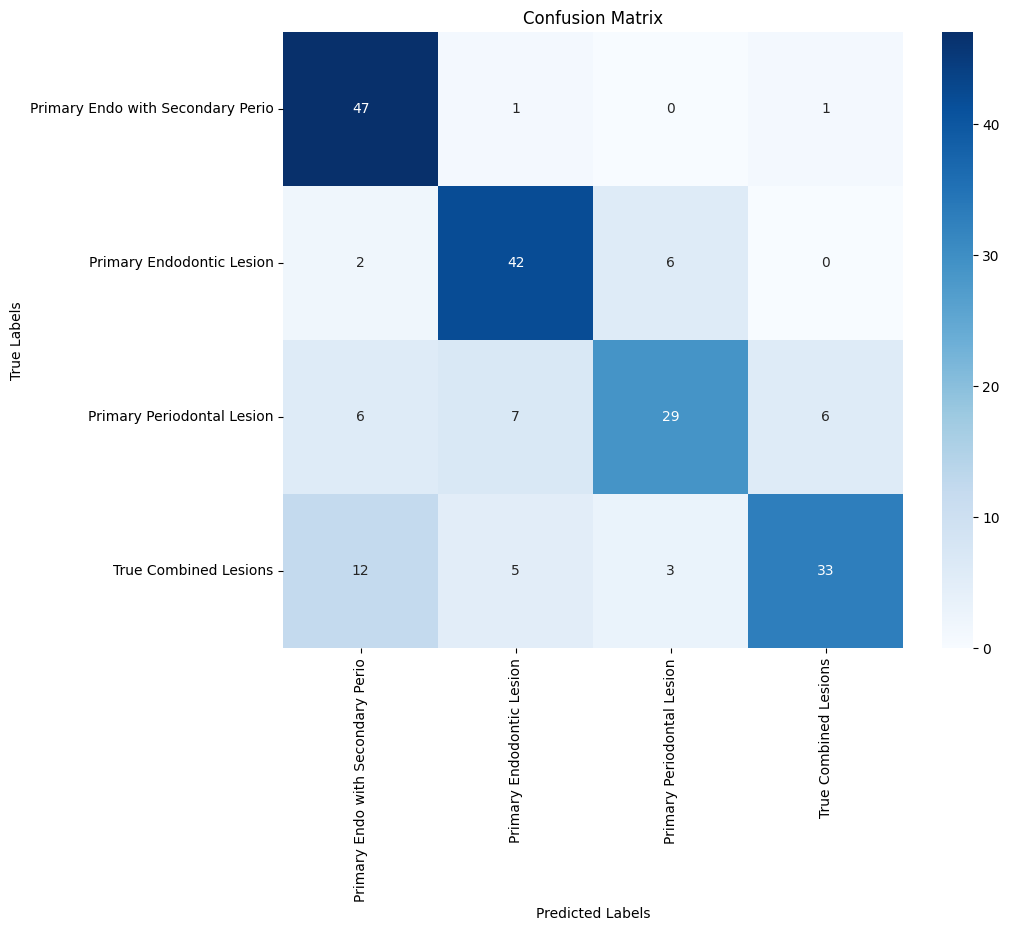

In [ ]:
test_generator1.reset()
predictions = model9.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

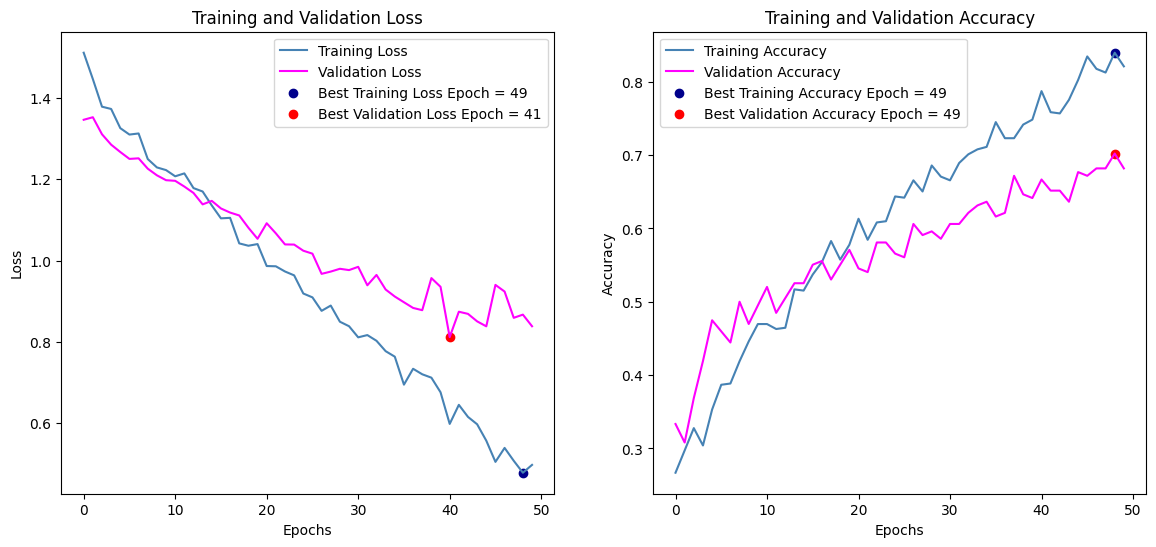

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history9.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history9.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history9.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history9.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history9.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history9.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history9.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history9.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history9.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history9.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history9.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history9.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.76
Recall: 0.76
F1-Score: 0.75
Accuracy: 0.76


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.70
  Recall: 0.96
  F1-Score: 0.81
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.76
  Recall: 0.84
  F1-Score: 0.80
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.76
  Recall: 0.60
  F1-Score: 0.67
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.82
  Recall: 0.62
  F1-Score: 0.71
  Support: 53

Overall Metrics:
Weighted Precision: 0.76
Weighted Recall: 0.76
Weighted F1-Score: 0.75
Accuracy: 0.76

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.701493  0.959184   
1                         Primary Endodontic Lesion   0.763636  0.840000   
2                        Primary Periodontal Lesion   0.763158  0.604167   
3                             True Combined Lesions   0.825000  0.622642   
Weighted Average                            Overall   0.764558  0.755000   



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model8 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model8.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model8.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,840,388 (167.24 MB)

 Trainable params: 2,268,548 (8.65 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history8 = model8.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2265 - loss: 1.7848 - val_accuracy: 0.3535 - val_loss: 1.3569 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 685ms/step - accuracy: 0.3147 - loss: 1.5290 - val_accuracy: 0.3737 - val_loss: 1.3255 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 687ms/step - accuracy: 0.3383 - loss: 1.4467 - val_accuracy: 0.3990 - val_loss: 1.3064 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 686ms/step - accuracy: 0.3623 - loss: 1.3989 - val_accuracy: 0.3990 - val_loss: 1.2749 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 654ms/step - accuracy: 0.3233 - loss: 1.3553 - val_accuracy: 0.4040 - val_loss: 1.2717 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 655ms/step - accuracy: 0.3797 - loss: 1.3717 - val_accuracy: 0.4798 - val_loss: 1.2360 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 676ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model8.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 766ms/step - accuracy: 0.7507 - loss: 0.7276
Test Accuracy: 68.50%


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


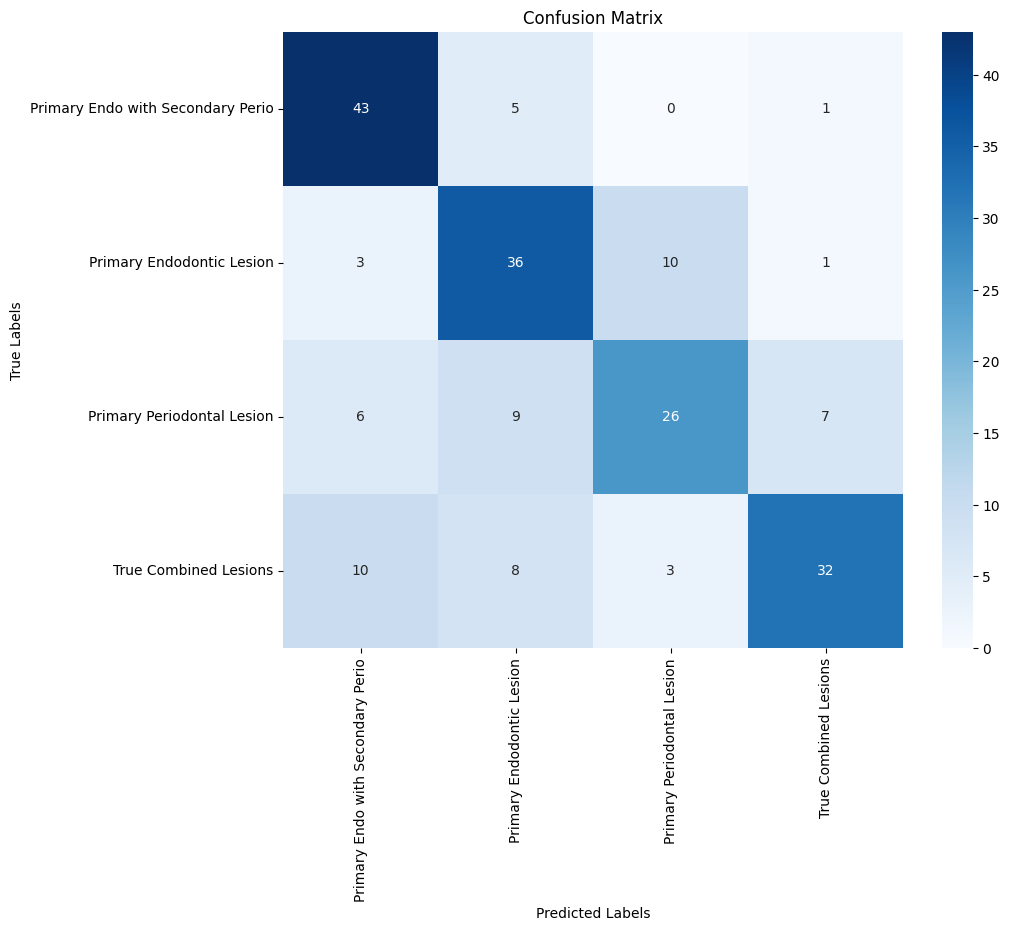

In [ ]:
test_generator1.reset()
predictions = model8.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

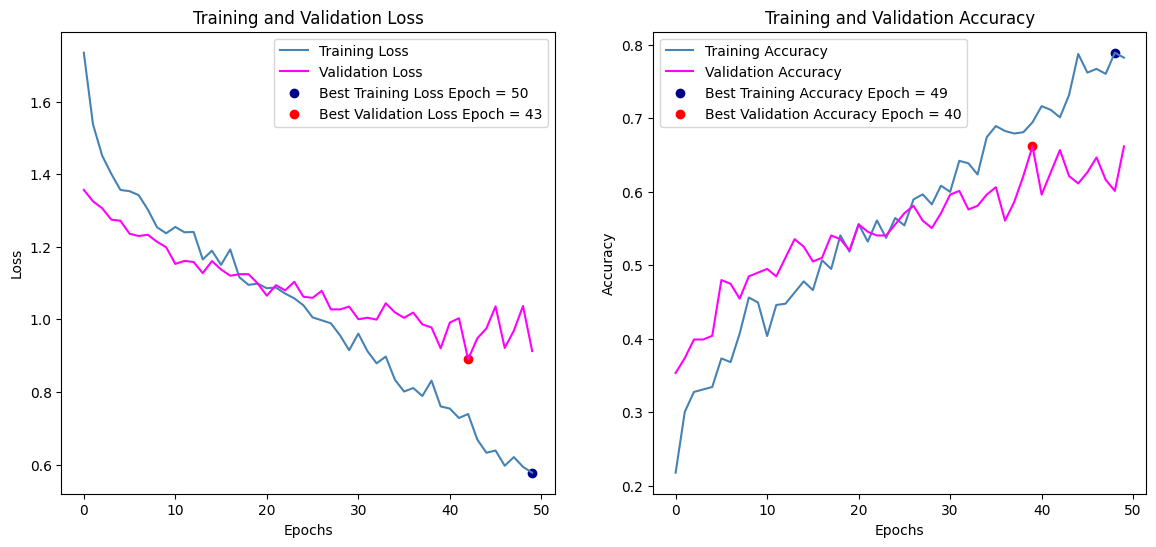

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history8.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history8.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history8.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history8.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history8.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history8.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history8.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history8.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history8.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history8.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history8.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history8.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.69
Recall: 0.69
F1-Score: 0.68
Accuracy: 0.69


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.69
  Recall: 0.88
  F1-Score: 0.77
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.62
  Recall: 0.72
  F1-Score: 0.67
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.67
  Recall: 0.54
  F1-Score: 0.60
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.78
  Recall: 0.60
  F1-Score: 0.68
  Support: 53

Overall Metrics:
Weighted Precision: 0.69
Weighted Recall: 0.69
Weighted F1-Score: 0.68
Accuracy: 0.69

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.693548  0.877551   
1                         Primary Endodontic Lesion   0.620690  0.720000   
2                        Primary Periodontal Lesion   0.666667  0.541667   
3                             True Combined Lesions   0.780488  0.603774   
Weighted Average                            Overall   0.691921  0.685000   

